<a href="https://colab.research.google.com/github/jmcaussade/Tarea1-Analitica-textual-con-ML/blob/main/Tarea1_Analitica_Textual_con_ML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 1 Alanítica textual con Machine Learning"
##Preprocesamiento de texto
### Integrantes:
#### - Jean Michel Caussade
#### - Sebastián Bobenrieth
#### - Juan Pablo Gazmuri


## Instalación de librerias

In [1]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.6 MB/s eta 0:00:00


In [2]:
pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 39.4 MB/s eta 0:00:00


In [3]:
pip install scikit-learn


Importar librerias necesarias


In [4]:
import os
import pandas as pd
import numpy as np
import re
# NLTK (Natural Language ToolKit) es una libreria para NLP
import nltk
# Existe extensiones que debemos descargar

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from collections import defaultdict
from collections import Counter
from unidecode import unidecode
from tqdm.notebook import tqdm
from itertools import chain
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Lectura base de datos en Google Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
ruta_data_set = '/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea1/COAH_dataset.xlsx'
#ruta_data_set = '/content/drive/My Drive//Tarea1/COAH_dataset.xlsx'
df = pd.read_excel(ruta_data_set)

Descripción de las variables a estudiar
1. **Id:** Identificador del comentario
2. **Rank:** Nota otorgada por el usuario (del 1 al 5, con 5 mayor satisfacción)
3. **Abstract:** Título del comentario (ingresado por el usuario)
4. **Review:** Cuerpo del comentario (ingresado por el usuario)


In [10]:
df.describe(include='all')

id         rank   abstract  \
count   1816.000000  1816.000000       1816   
unique          NaN          NaN       1681   
top             NaN          NaN  Excelente   
freq            NaN          NaN         15   
mean     908.500000     3.400881        NaN   
std      524.378362     1.440875        NaN   
min        1.000000     1.000000        NaN   
25%      454.750000     2.000000        NaN   
50%      908.500000     4.000000        NaN   
75%     1362.250000     5.000000        NaN   
max     1816.000000     5.000000        NaN   

                                                   review  
count                                                1816  
unique                                               1792  
top     La peor experiencia que he tenido en un hotel....  
freq                                                    2  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

# Análisis Exploratorio de Datos: Variable Objetivo

Para analizar el comportamiento de los datos de la variable objetivo (rating), generamos un gráfico de barras.

rank
5    531
4    489
1    312
3    285
2    199
Name: count, dtype: int64


<Axes: xlabel='rank'>

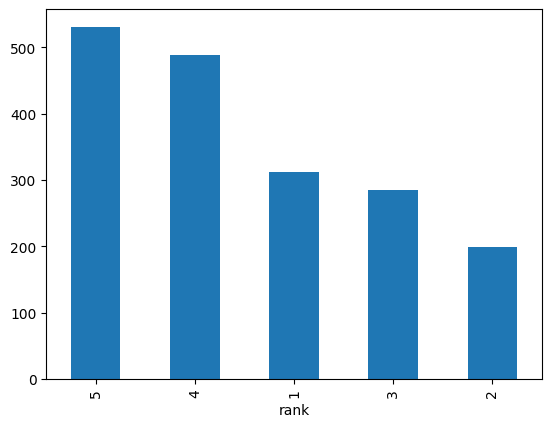

In [11]:
print(df['rank'].value_counts())
df['rank'].value_counts().plot(kind='bar')

In [12]:
print(df['rank'].unique())


[5 4 3 2 1]


Utilizaremos la definición clásica en análisis de sentimientos **recodificando** el rating en los siguientes valores:

1 y 2 -> 0 (Negativo)

3 -> 1 (Neutro)

4 y 5 -> 2 (Positivo)



rank
2    1020
0     511
1     285
Name: count, dtype: int64


<Axes: xlabel='rank'>

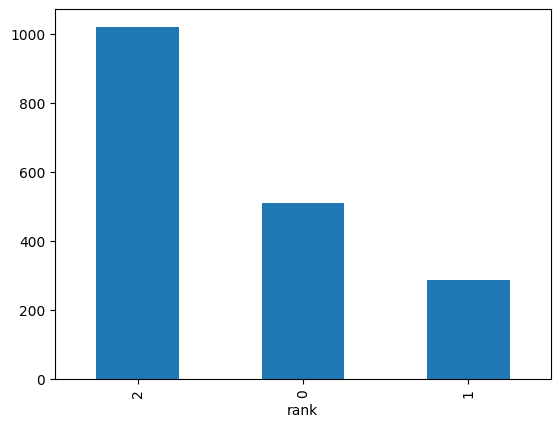

In [13]:
df['rank'] = df['rank'].replace({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})

# Imprimir y graficar la distribucion de los ratings simplificados
print(df['rank'].value_counts())
df['rank'].value_counts().plot(kind='bar')

# Procesamiento de texto

Los pasos son:

1. **Limpieza**, la remoción del contenido no deseado.
2. **Normalización**, la conversión diferentes formas a una sola.
3. **Tokenización**, la separación del texto en tókenes (unidades mínimas, por ejemplo palabras).
4. Separación en **conjuntos de datos**: entrenamiento, validación, prueba.
5. Generación del **vocabulario**, la lista de tókenes conocidos.
6. **Numericalización**, el mapeo de tókenes a números enteros.
7. Corregir ortografía

Estos pasos son comunes distintas aproximaciones al procesamiento del lenguaje.

## Limpieza

In [14]:
def limpiar(texto):
    puntuación = r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']'

    # signos de puntuación
    texto = re.sub(puntuación, ' ', texto)

    # dígitos [0-9]
    texto = re.sub('\d', ' ', texto)

    return texto

## Normalización


In [15]:
def normalizar(tokens):
    normalized_tokens = []
    for token in tokens:
      # todo a minúsculas
      texto = token.lower()

      # tildes y diacríticas
      texto = re.sub('á', 'a', texto)
      texto = re.sub('é', 'e', texto)
      texto = re.sub('í', 'i', texto)
      texto = re.sub('ó', 'o', texto)
      texto = re.sub('ú', 'u', texto)
      texto = re.sub('ü', 'u', texto)
      texto = re.sub('ñ', 'n', texto)
      normalized_tokens.append(texto)
    return normalized_tokens

## Unicode


In [16]:
def repazo_unicode(tokens):
    unicode_fixed_tokens = [unidecode(token) for token in tokens if len(token) >= 3]
    return unicode_fixed_tokens

## Corregir ortografía???

In [ ]:
# def correct_spelling(tokens):
#     spell = SpellChecker(language='es')  # Initialize the SpellChecker for Spanish
#     corrected_tokens = []

#     for token in tokens:
#         if token.isalpha() and len(token) > 2:  # Ensure it's a valid word to correct
#             if token not in spell:  # Check if the token is not in the dictionary
#                 # Get the most probable correction for the misspelled word
#                 corrected_token = spell.correction(token)

#                 # Print the misspelled word and its correction
#                 print(f"Misspelled word: {token}")
#                 print(f"Chosen correction: {corrected_token}")

#                 corrected_tokens.append(corrected_token)
#             else:
#                 corrected_tokens.append(token)  # If the token is already correct, keep it unchanged
#         else:
#             corrected_tokens.append(token)  # Add non-word tokens unchanged

#     return corrected_tokens

## Tokenización


In [17]:
def texto_tokenizer(texto):
    tokens = word_tokenize(texto)
    return tokens

## Lemmatizacion





In [18]:
nltk.download("wordnet")
nltk.download("omw-1.4")
wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:
def texto_lematization(texto_tokenizado, wnl):
    lemmatized_tokens = []
    for token in texto_tokenizado:
        # Check if the token is alphabetic
        if token.isalpha():
            # Lemmatize the token and add to the list
            lemmatized_token = wnl.lemmatize(token)
            lemmatized_tokens.append(lemmatized_token)
        else:
            # If it's not a word (e.g., punctuation), add it unchanged
            lemmatized_tokens.append(token)

    return lemmatized_tokens


### Stop Words

In [20]:
# Define additional stop words
additional_stopwords = {}

# Combine existing Spanish stop words with additional stop words
spanish_stopwords = set(stopwords.words('spanish')).union(additional_stopwords)

def rem_stopwords(tokens):
    texto_final = []
    for token, tag in pos_tag(tokens):
        if token.lower() not in spanish_stopwords:  # Convert token to lowercase for matching
            texto_final.append(token)
    return texto_final

rem_stopwords2 = lambda tokens: [token for token, tag in pos_tag(tokens) if token.lower() not in spanish_stopwords]

In [21]:
def preprocesar1(texto):
    texto = limpiar(texto)
    texto = texto_tokenizer(texto)
    #texto = correct_spelling(texto)
    texto = rem_stopwords(texto)
    texto = texto_lematization(texto, wnl)
    texto = normalizar(texto)
    texto = repazo_unicode(texto)
    return texto

¡¡¡¡¡¡CELDA DE ABAJO SE DEBE CORRER 2 VECES!!!!!
La primera vez tira error y la segunda corre bien

---



In [23]:
for index, row in df.iterrows():
    review_text = row['review']

    processed_review = preprocesar1(review_text)
    print(f"processed_review: {processed_review}")

    df.at[index, 'processed_review'] = processed_review

processed_review: ['bien', 'comente', 'propietarios', 'hora', 'abandonar', 'hotel', 'dudare', 'momento', 'recomendar', 'vez', 'hotel', 'albero', 'granada', 'situacion', 'respecto', 'centro', 'granada', 'mejor', 'propositos', 'perfecto', 'escapada', 'fin', 'semana', 'visita', 'alhambra', 'encuentra', 'carretera', 'paso', 'sierra', 'nevada', 'cercano', 'alhambra', 'zona', 'puede', 'encontrar', 'aparcamiento', 'encuentra', 'zona', 'segura', 'tranquila', 'parking', 'centro', 'granada', 'recomendaron', 'hotel', 'dijeron', 'caros', 'pudimos', 'movernos', 'centro', 'perfectamente', 'alli', 'habitaciones', 'limpias', 'camas', 'confortables', 'desayuno', 'espectacular', 'buenas', 'referencias', 'maravilloso', 'hotel', 'estrella', 'viajo', 'constantemente', 'superado', 'creces', 'expectativas', 'vuelvo', 'granada', 'dudare', 'hospedarme', 'mismo', 'hotel', 'muchas', 'gracias']
processed_review: ['dias', 'familia', 'reservando', 'habitaciones', 'desayuno', 'incluido', 'incluso', 'cogi', 'parking'

In [24]:
df

id  rank                                          abstract  \
0        1     2                        Un hotel digno de mención!   
1        2     2  Recomendable 100%, sin lujos pero todo perfecto.   
2        3     1                                         Decepción   
3        4     2                      Por segunda vez, inmejorable   
4        5     2                                   No tan sorpresa   
...    ...   ...                                               ...   
1811  1812     2           remanso de paz en el corazón de Córdoba   
1812  1813     2             Oasis de paz, tranquilidad y belleza!   
1813  1814     2                            Un lugar para recordar   
1814  1815     2                                    Extraordinario   
1815  1816     2  Ojalá hubiese hoteles así en todas las ciudades.   

                                                 review  \
0     Como bien les comenté a los propietarios a la ...   
1     Estuvimos dos días con mi familia, reservando ...   
2     Habíamos escogido este hotel por las buenas op...   
3     Hemos vuelto por segunda vez a este estupendo ...   
4     He estado dos días en Granada por trabajo, soy...   
...                                                 ...   
1811  Hemos empezado el año con una estancia de tres...   
1812  Al atravesar el umbral de la puerta que conduc...   
1813  En este hotel todo son sensaciones y experienc...   
1814  Hemos pasado un par de noches en este exquisit...   
1815  El hotel es precioso, esta muy bien ubicado pa...   

                                       processed_review  
0     [bien, comente, propietarios, hora, abandonar,...  
1     [dias, familia, reservando, habitaciones, desa...  
2     [escogido, hotel, buenas, opiniones, verdad, h...  
3     [vuelto, segunda, vez, estupendo, hotel, grana...  
4     [dias, granada, trabajo, autonomo, busco, ante...  
...                                                 ...  
1811  [empezado, ano, estancia, tres, noches, hotel,...  
1812  [atravesar, umbral, puerta, conduce, zaguan, h...  
1813  [hotel, sensaciones, experiencias, positivas, ...  
1814  [pasado, par, noches, exquisito, hotel, regent...  
1815  [hotel, precioso, bien, ubicado, recorrer, cor...  

[1816 rows x 5 columns]

## Vocabulario

#### Elementos más comunes


In [25]:
def counter(token_list):
  count = Counter(token_list)
  return count

#### Chaining lists of lists

In [26]:
def to_single_list(list_of_lists):
    return list(chain.from_iterable(list_of_lists))

In [27]:
token_list1 = to_single_list(df['processed_review'])

In [28]:
print(counter(token_list1))

Counter({'hotel': 2884, 'habitacion': 1224, 'bien': 1041, 'habitaciones': 901, 'personal': 773, 'dia': 648, 'desayuno': 584, 'solo': 493, 'piscina': 472, 'bano': 466, 'precio': 437, 'recepcion': 431, 'noche': 423, 'zona': 412, 'buena': 412, 'bastante': 398, 'comida': 395, 'calidad': 384, 'aunque': 365, 'centro': 338, 'mejor': 330, 'servicio': 314, 'limpieza': 313, 'bueno': 297, 'trato': 287, 'playa': 284, 'toda': 278, 'semana': 276, 'mal': 274, 'fin': 272, 'dias': 269, 'ubicacion': 265, 'asi': 264, 'estrellas': 260, 'ademas': 256, 'vista': 255, 'puede': 253, 'buen': 249, 'ser': 248, 'ciudad': 245, 'verdad': 242, 'vez': 240, 'cama': 238, 'parking': 228, 'estancia': 228, 'menos': 227, 'cerca': 224, 'persona': 224, 'coche': 222, 'minutos': 221, 'alli': 217, 'siempre': 217, 'decir': 217, 'recomiendo': 216, 'amable': 213, 'mismo': 212, 'restaurante': 204, 'gente': 204, 'situado': 204, 'lugar': 203, 'agradable': 203, 'calle': 201, 'atencion': 201, 'excelente': 200, 'tan': 196, 'agua': 196, '

#### Class Vocabulario

In [29]:
class Vocab():
    def __init__(self, tóken_desconocido='<unk>', frecuencia_mínima=0.0, frecuencia_máxima=1.0,
                 longitud_mínima=1, longitud_máxima=np.inf, stop_words=[], límite_vocabulario=None):

        self.tóken_desconocido = tóken_desconocido
        self.frecuencia_mínima = frecuencia_mínima
        self.frecuencia_máxima = frecuencia_máxima
        self.longitud_mínima = longitud_mínima
        self.longitud_máxima = longitud_máxima
        self.stop_words = stop_words
        self.límite_vocabulario = límite_vocabulario

    def reducir_vocabulario(self, lote):
        contador_absoluto = Counter(chain(*lote))

        contador_documentos = Counter()

        for doc in lote:
            contador_documentos.update(set(doc))

        # frecuencia mínima
        if isinstance(self.frecuencia_mínima, int): # frecuencia de tóken
            vocabulario_mín = [tóken for tóken, frecuencia in contador_absoluto.most_common() if frecuencia >= self.frecuencia_mínima]
        else: # frecuencia de documento
            vocabulario_mín = [tóken for tóken, frecuencia in contador_documentos.most_common() if frecuencia/len(lote) >= self.frecuencia_mínima]

        # frecuencia máxima
        if isinstance(self.frecuencia_máxima, int): # frecuencia de tóken
            vocabulario_máx = [tóken for tóken, frecuencia in contador_absoluto.most_common() if self.frecuencia_máxima >= frecuencia]
        else: # frecuencia de documento
            vocabulario_máx = [tóken for tóken, frecuencia in contador_documentos.most_common() if self.frecuencia_máxima >= frecuencia/len(lote)]

        # intersección de vocabulario_mín y vocabulario_máx preservando el órden
        vocabulario = [tóken for tóken in vocabulario_mín if tóken in vocabulario_máx]

        # longitud
        vocabulario = [tóken for tóken in vocabulario if self.longitud_máxima >= len(tóken) >= self.longitud_mínima]

        # stop words
        vocabulario = [tóken for tóken in vocabulario if tóken not in self.stop_words]

        # límite
        vocabulario = vocabulario[:self.límite_vocabulario]

        return vocabulario

    def fit(self, lote):
        vocabulario = self.reducir_vocabulario(lote)

        if self.tóken_desconocido:
            vocabulario.append(self.tóken_desconocido)

        self.mapeo = {tóken: índice for índice, tóken in enumerate(vocabulario)}

        return self

    def transform(self, lote):
        if self.tóken_desconocido: # reemplazar
            return [[tóken if tóken in self.mapeo else self.tóken_desconocido for tóken in doc] for doc in lote]
        else: # ignorar
            return [[tóken for tóken in doc if tóken in self.mapeo] for doc in lote]

    def tókenes_a_índices(self, lote):
        lote = self.transform(lote)

        return [[self.mapeo[tóken] for tóken in doc] for doc in lote]

    def índices_a_tókenes(self, lote):
        mapeo_inverso = list(self.mapeo.keys())

        return [[mapeo_inverso[índice] for índice in doc] for doc in lote]

    def print_vocabulario(self):
        for tóken, índice in self.mapeo.items():
            print(f"{tóken}: {índice}")

    def __len__(self):
        return len(self.mapeo)


In [30]:
token_lists = df['processed_review'].tolist()

In [31]:
print(token_lists)

[['bien', 'comente', 'propietarios', 'hora', 'abandonar', 'hotel', 'dudare', 'momento', 'recomendar', 'vez', 'hotel', 'albero', 'granada', 'situacion', 'respecto', 'centro', 'granada', 'mejor', 'propositos', 'perfecto', 'escapada', 'fin', 'semana', 'visita', 'alhambra', 'encuentra', 'carretera', 'paso', 'sierra', 'nevada', 'cercano', 'alhambra', 'zona', 'puede', 'encontrar', 'aparcamiento', 'encuentra', 'zona', 'segura', 'tranquila', 'parking', 'centro', 'granada', 'recomendaron', 'hotel', 'dijeron', 'caros', 'pudimos', 'movernos', 'centro', 'perfectamente', 'alli', 'habitaciones', 'limpias', 'camas', 'confortables', 'desayuno', 'espectacular', 'buenas', 'referencias', 'maravilloso', 'hotel', 'estrella', 'viajo', 'constantemente', 'superado', 'creces', 'expectativas', 'vuelvo', 'granada', 'dudare', 'hospedarme', 'mismo', 'hotel', 'muchas', 'gracias'], ['dias', 'familia', 'reservando', 'habitaciones', 'desayuno', 'incluido', 'incluso', 'cogi', 'parking', 'privado', 'estancia', 'perfecta

In [32]:
vocab = Vocab(
    tóken_desconocido='<unk>',
    frecuencia_mínima=50,
    frecuencia_máxima=500,
    longitud_mínima=3,
    longitud_máxima=10,
    stop_words=["asi", "ano","anos", "aun"],
    límite_vocabulario=None
)


In [33]:
vocabulario1 = vocab.fit(token_lists)

In [34]:
vocabulario1.print_vocabulario()

solo: 0
piscina: 1
bano: 2
precio: 3
recepcion: 4
noche: 5
zona: 6
buena: 7
bastante: 8
comida: 9
calidad: 10
aunque: 11
centro: 12
mejor: 13
servicio: 14
limpieza: 15
bueno: 16
trato: 17
playa: 18
toda: 19
semana: 20
mal: 21
fin: 22
dias: 23
ubicacion: 24
estrellas: 25
ademas: 26
vista: 27
puede: 28
buen: 29
ser: 30
ciudad: 31
verdad: 32
vez: 33
cama: 34
parking: 35
estancia: 36
menos: 37
cerca: 38
persona: 39
coche: 40
minutos: 41
alli: 42
siempre: 43
decir: 44
recomiendo: 45
amable: 46
mismo: 47
gente: 48
situado: 49
lugar: 50
agradable: 51
calle: 52
atencion: 53
excelente: 54
tan: 55
agua: 56
buffet: 57
pues: 58
llegar: 59
peor: 60
terraza: 61
pequena: 62
limpio: 63
unico: 64
lado: 65
parte: 66
ninos: 67
gusto: 68
sitio: 69
camas: 70
grande: 71
hostal: 72
unas: 73
sido: 74
aire: 75
cada: 76
hoteles: 77
pasar: 78
ver: 79
hacer: 80
puerta: 81
creo: 82
hace: 83
despues: 84
habia: 85
comer: 86
cordoba: 87
pequeno: 88
pasado: 89
general: 90
patio: 91
tener: 92
variedad: 93
encanto: 94
r

In [35]:
def filter_words_by_vocabulario(words, vocabulario):
    return [word for word in words if word in vocabulario.mapeo]

In [36]:
def contar_palabras_por_rank(df, rank):
    textos = df[df['rank'] == rank]['filtered_words']
    conteo_total = Counter(chain(*textos))
    return conteo_total

In [37]:
# Apply the function to each review
df['filtered_words'] = df['processed_review'].apply(lambda tokens: filter_words_by_vocabulario(tokens, vocabulario1))

In [38]:
df

id  rank                                          abstract  \
0        1     2                        Un hotel digno de mención!   
1        2     2  Recomendable 100%, sin lujos pero todo perfecto.   
2        3     1                                         Decepción   
3        4     2                      Por segunda vez, inmejorable   
4        5     2                                   No tan sorpresa   
...    ...   ...                                               ...   
1811  1812     2           remanso de paz en el corazón de Córdoba   
1812  1813     2             Oasis de paz, tranquilidad y belleza!   
1813  1814     2                            Un lugar para recordar   
1814  1815     2                                    Extraordinario   
1815  1816     2  Ojalá hubiese hoteles así en todas las ciudades.   

                                                 review  \
0     Como bien les comenté a los propietarios a la ...   
1     Estuvimos dos días con mi familia, reservando ...   
2     Habíamos escogido este hotel por las buenas op...   
3     Hemos vuelto por segunda vez a este estupendo ...   
4     He estado dos días en Granada por trabajo, soy...   
...                                                 ...   
1811  Hemos empezado el año con una estancia de tres...   
1812  Al atravesar el umbral de la puerta que conduc...   
1813  En este hotel todo son sensaciones y experienc...   
1814  Hemos pasado un par de noches en este exquisit...   
1815  El hotel es precioso, esta muy bien ubicado pa...   

                                       processed_review  \
0     [bien, comente, propietarios, hora, abandonar,...   
1     [dias, familia, reservando, habitaciones, desa...   
2     [escogido, hotel, buenas, opiniones, verdad, h...   
3     [vuelto, segunda, vez, estupendo, hotel, grana...   
4     [dias, granada, trabajo, autonomo, busco, ante...   
...                                                 ...   
1811  [empezado, ano, estancia, tres, noches, hotel,...   
1812  [atravesar, umbral, puerta, conduce, zaguan, h...   
1813  [hotel, sensaciones, experiencias, positivas, ...   
1814  [pasado, par, noches, exquisito, hotel, regent...   
1815  [hotel, precioso, bien, ubicado, recorrer, cor...   

                                         filtered_words  
0     [hora, momento, vez, granada, situacion, centr...  
1     [dias, familia, incluido, incluso, parking, es...  
2     [buenas, verdad, centro, hacia, ruido, poder, ...  
3     [vez, estupendo, granada, relacion, calidad, p...  
4     [dias, granada, elegir, pues, situacion, cerca...  
...                                                 ...  
1811  [estancia, tres, noches, lugar, tranquilo, tra...  
1812  [puerta, olor, natural, patio, patio, calidad,...  
1813  [ubicado, antigua, calle, ahora, junto, zona, ...  
1814  [pasado, par, noches, trato, primera, planta, ...  
1815  [precioso, ubicado, cordoba, pie, cuenta, park...  

[1816 rows x 6 columns]

# Analisis exploratorio de datos: Información textual

In [39]:
# Step 1: Count the number of tokens in each row
df['token_count'] = df['processed_review'].apply(len)

# Step 2: Compute statistics grouped by 'rank'
grouped_stats = df.groupby('rank')['token_count'].agg(['min', 'max', 'mean', 'count']).reset_index()

# Rename columns for clarity
grouped_stats.columns = ['Rank', 'Min', 'Max', 'Average', 'Count']

# Add global statistics
global_stats = pd.DataFrame({
    'Rank': ['Global'],
    'Min': [df['token_count'].min()],
    'Max': [df['token_count'].max()],
    'Average': [df['token_count'].mean()],
    'Count': [len(df)]
})

# Concatenate global statistics with the grouped statistics
analisis_df = pd.concat([global_stats, grouped_stats], ignore_index=True)

# Print the new DataFrame
print(analisis_df)

     Rank  Min  Max    Average  Count
0  Global    5  611  59.829846   1816
1       0   10  408  75.909980    511
2       1    5  611  61.203509    285
3       2    6  390  51.390196   1020


## Matrix

In [40]:
# Join tokens into single strings
df['joined_text'] = df['filtered_words'].apply(lambda tokens: ' '.join(tokens))

In [41]:
print(df['joined_text'].head())

0    hora momento vez granada situacion centro gran...
1    dias familia incluido incluso parking estancia...
2    buenas verdad centro hacia ruido poder suelo p...
3    vez estupendo granada relacion calidad precio ...
4    dias granada elegir pues situacion cerca grana...
Name: joined_text, dtype: object


In [42]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialize CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the joined documents
X = count_vectorizer.fit_transform(df['joined_text'])

In [43]:
# Convert the matrix to a DataFrame for easy analysis
df_word_matrix = pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names_out())

# Display the first few rows of the matrix
print(df_word_matrix.head())

   acceso  acogedor  ademas  agosto  agradable  agua  ahi  ahora  aire  algun  \
0       0         0       0       0          0     0    0      0     0      0   
1       0         0       0       0          0     0    0      0     0      0   
2       0         0       0       0          0     0    0      0     0      0   
3       0         0       1       0          0     0    0      0     0      0   
4       0         0       0       0          0     0    0      0     0      0   

   ...  vista  visto  volver  volvere  volveremos  volveria  voy  wifi  zona  \
0  ...      0      0       0        0           0         0    0     0     2   
1  ...      0      0       0        0           0         0    0     0     0   
2  ...      0      0       0        0           0         0    0     0     0   
3  ...      0      0       0        0           0         0    0     0     0   
4  ...      0      0       0        0           0         0    0     1     1   

   zumo  
0     0  
1     0  
2 

In [44]:
df_word_matrix

acceso  acogedor  ademas  agosto  agradable  agua  ahi  ahora  aire  \
0          0         0       0       0          0     0    0      0     0   
1          0         0       0       0          0     0    0      0     0   
2          0         0       0       0          0     0    0      0     0   
3          0         0       1       0          0     0    0      0     0   
4          0         0       0       0          0     0    0      0     0   
...      ...       ...     ...     ...        ...   ...  ...    ...   ...   
1811       0         0       0       0          0     0    1      0     0   
1812       0         0       0       0          0     1    0      0     0   
1813       0         0       1       0          0     0    0      1     0   
1814       0         0       0       0          0     0    0      0     0   
1815       0         0       0       0          0     0    0      0     0   

      algun  ...  vista  visto  volver  volvere  volveremos  volveria  voy  \
0         0  ...      0      0       0        0           0         0    0   
1         0  ...      0      0       0        0           0         0    0   
2         0  ...      0      0       0        0           0         0    0   
3         0  ...      0      0       0        0           0         0    0   
4         0  ...      0      0       0        0           0         0    0   
...     ...  ...    ...    ...     ...      ...         ...       ...  ...   
1811      0  ...      1      0       0        0           0         0    0   
1812      0  ...      1      0       0        0           0         0    0   
1813      0  ...      0      0       0        0           0         0    0   
1814      0  ...      0      0       0        0           0         0    0   
1815      0  ...      0      0       0        0           0         0    0   

      wifi  zona  zumo  
0        0     2     0  
1        0     0     0  
2        0     0     0  
3        0     0     0  
4        1     1     0  
...    ...   ...   ...  
1811     0     2     0  
1812     0     0     1  
1813     0     1     0  
1814     0     0     0  
1815     0     0     0  

[1816 rows x 387 columns]

In [47]:
print(df_word_matrix.shape)

(1816, 387)


In [51]:
from sklearn.feature_extraction.text import TfidfTransformer

# Initialize TfidfTransformer
tfidf_transformer = TfidfTransformer()

# Fit and transform the term frequency matrix
tfidf_matrix = tfidf_transformer.fit_transform(df_word_matrix)

# Print the TF-IDF matrix in sparse format
print(tfidf_matrix)



  (0, 385)	0.1975363830975293
  (0, 372)	0.11175568916329813
  (0, 353)	0.1563386064032016
  (0, 330)	0.12989553763526168
  (0, 319)	0.10609022741020584
  (0, 298)	0.10976407686486825
  (0, 296)	0.1644924030025573
  (0, 274)	0.13824884276916552
  (0, 262)	0.15179348629684206
  (0, 255)	0.11553779834523675
  (0, 229)	0.1463711198734011
  (0, 227)	0.13105847839980672
  (0, 224)	0.1147853471043981
  (0, 215)	0.10058489926387365
  (0, 197)	0.13105847839980672
  (0, 178)	0.1335064749261377
  (0, 165)	0.5589205841074354
  (0, 163)	0.13382480971594113
  (0, 155)	0.1066765035516722
  (0, 139)	0.29844954419420244
  (0, 138)	0.15126451761897
  (0, 126)	0.1644924030025573
  (0, 68)	0.2945486728602533
  (0, 57)	0.12108715318890884
  (0, 44)	0.13047220225834036
  :	:
  (1814, 334)	0.29108251987712436
  (1814, 298)	0.22424054456937564
  (1814, 293)	0.26834999001250814
  (1814, 280)	0.27811998958374323
  (1814, 257)	0.2581477694195215
  (1814, 249)	0.3329883879641452
  (1814, 242)	0.2980989837191929


In [52]:
# Convert the TF-IDF matrix to a DataFrame
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=df_word_matrix.columns)

In [53]:
# Print the DataFrame to inspect the result
print(df_tfidf.shape)

(1816, 387)


In [54]:
df_tfidf

acceso  acogedor    ademas  agosto  agradable      agua      ahi  \
0        0.0       0.0  0.000000     0.0        0.0  0.000000  0.00000   
1        0.0       0.0  0.000000     0.0        0.0  0.000000  0.00000   
2        0.0       0.0  0.000000     0.0        0.0  0.000000  0.00000   
3        0.0       0.0  0.165219     0.0        0.0  0.000000  0.00000   
4        0.0       0.0  0.000000     0.0        0.0  0.000000  0.00000   
...      ...       ...       ...     ...        ...       ...      ...   
1811     0.0       0.0  0.000000     0.0        0.0  0.000000  0.17762   
1812     0.0       0.0  0.000000     0.0        0.0  0.101535  0.00000   
1813     0.0       0.0  0.119894     0.0        0.0  0.000000  0.00000   
1814     0.0       0.0  0.000000     0.0        0.0  0.000000  0.00000   
1815     0.0       0.0  0.000000     0.0        0.0  0.000000  0.00000   

         ahora  aire  algun  ...     vista  visto  volver  volvere  \
0     0.000000   0.0    0.0  ...  0.000000    0.0     0.0      0.0   
1     0.000000   0.0    0.0  ...  0.000000    0.0     0.0      0.0   
2     0.000000   0.0    0.0  ...  0.000000    0.0     0.0      0.0   
3     0.000000   0.0    0.0  ...  0.000000    0.0     0.0      0.0   
4     0.000000   0.0    0.0  ...  0.000000    0.0     0.0      0.0   
...        ...   ...    ...  ...       ...    ...     ...      ...   
1811  0.000000   0.0    0.0  ...  0.119102    0.0     0.0      0.0   
1812  0.000000   0.0    0.0  ...  0.092896    0.0     0.0      0.0   
1813  0.178026   0.0    0.0  ...  0.000000    0.0     0.0      0.0   
1814  0.000000   0.0    0.0  ...  0.000000    0.0     0.0      0.0   
1815  0.000000   0.0    0.0  ...  0.000000    0.0     0.0      0.0   

      volveremos  volveria  voy      wifi      zona      zumo  
0            0.0       0.0  0.0  0.000000  0.197536  0.000000  
1            0.0       0.0  0.0  0.000000  0.000000  0.000000  
2            0.0       0.0  0.0  0.000000  0.000000  0.000000  
3            0.0       0.0  0.0  0.000000  0.000000  0.000000  
4            0.0       0.0  0.0  0.148257  0.100352  0.000000  
...          ...       ...  ...       ...       ...       ...  
1811         0.0       0.0  0.0  0.000000  0.216223  0.000000  
1812         0.0       0.0  0.0  0.000000  0.000000  0.135069  
1813         0.0       0.0  0.0  0.000000  0.108358  0.000000  
1814         0.0       0.0  0.0  0.000000  0.000000  0.000000  
1815         0.0       0.0  0.0  0.000000  0.000000  0.000000  

[1816 rows x 387 columns]

In [57]:
## DESCOMENTAR PARA EXPORTAR MATRIZ
#df_tfidf.to_csv('tfidf_matrix.csv', index=False)


In [56]:
# Sum the TF-IDF scores for each term across all documents
term_scores = df_tfidf.sum(axis=0)

# Convert to a DataFrame for better readability
df_term_scores = pd.DataFrame(term_scores, index=df_tfidf.columns, columns=['Total TF-IDF'])

# Sort by the total TF-IDF score
df_term_scores_sorted = df_term_scores.sort_values(by='Total TF-IDF', ascending=False)

print(df_term_scores_sorted.head(30))

           Total TF-IDF
piscina       56.821610
buena         56.592058
precio        55.826388
bano          55.742003
solo          55.615608
bastante      53.055242
zona          51.970603
comida        51.686037
recepcion     51.610004
centro        51.465244
calidad       50.840700
noche         50.663457
servicio      49.710741
aunque        46.423058
mejor         46.289956
trato         46.076144
ubicacion     44.909970
limpieza      44.164757
bueno         43.187461
playa         41.433888
ciudad        41.332146
buen          41.090522
estrellas     40.923819
semana        40.677791
mal           40.381918
vista         39.227207
fin           39.127401
dias          38.925646
excelente     38.839169
amable        38.207169


# Nube de Palabras

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [59]:
def crear_wordcloud(conteo_palabras, titulo):
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(conteo_palabras)
    plt.figure(figsize=(10, 5))
    plt.title(titulo)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [60]:
conteo_rank_0 = contar_palabras_por_rank(df, 0)
conteo_rank_1 = contar_palabras_por_rank(df, 1)
conteo_rank_2 = contar_palabras_por_rank(df, 2)

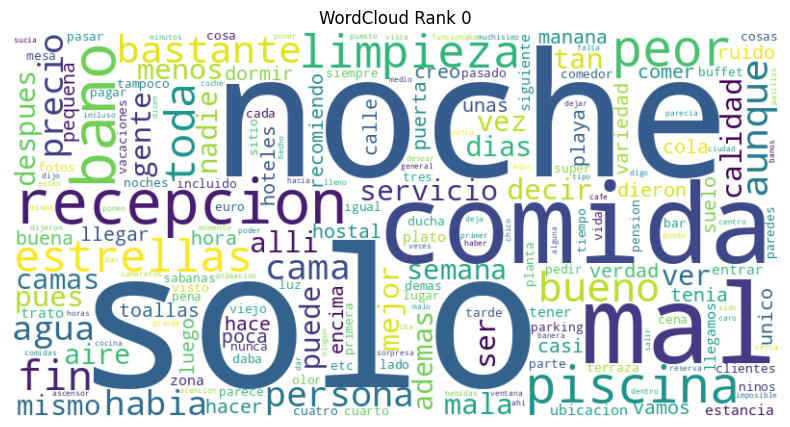

In [61]:
crear_wordcloud(conteo_rank_0, 'WordCloud Rank 0')

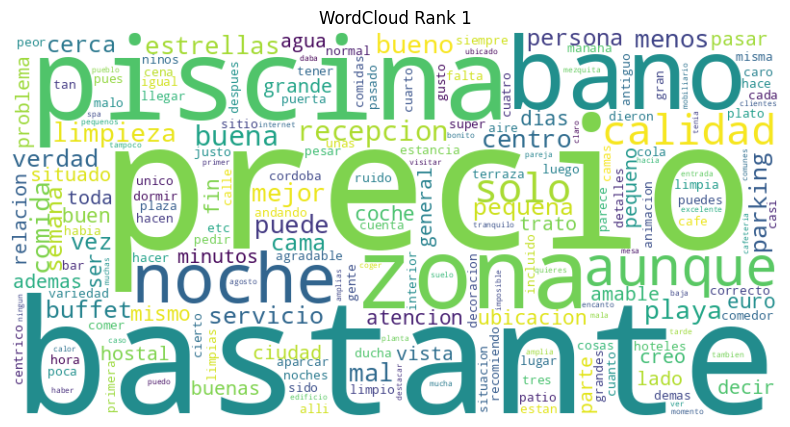

In [62]:
crear_wordcloud(conteo_rank_1, 'WordCloud Rank 1')

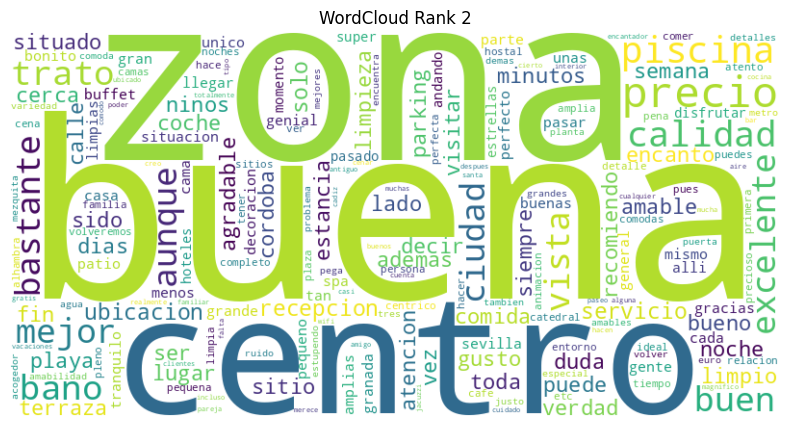

In [63]:
crear_wordcloud(conteo_rank_2, 'WordCloud Rank 2')

#Biagrama

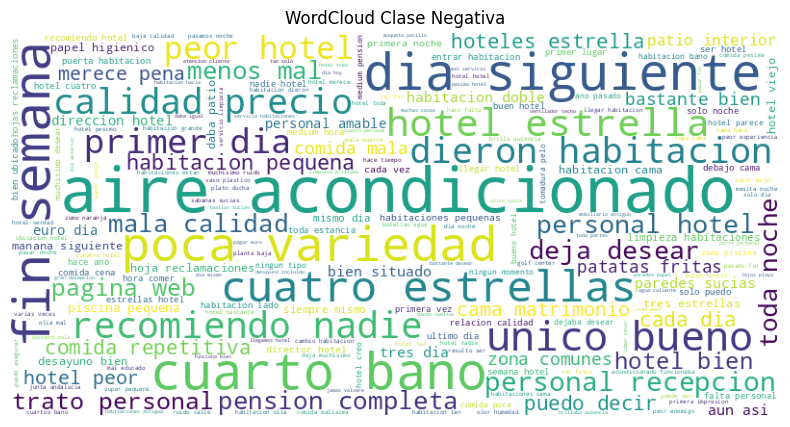

In [64]:
# Clase Negativa (0)
texto_unido_n = ' '.join(df[df['rank'] == 0]['processed_review'].sum())
wordcloud_n = WordCloud(width=800, height=400, background_color='white', collocation_threshold = 3).generate(texto_unido_n)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Negativa')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

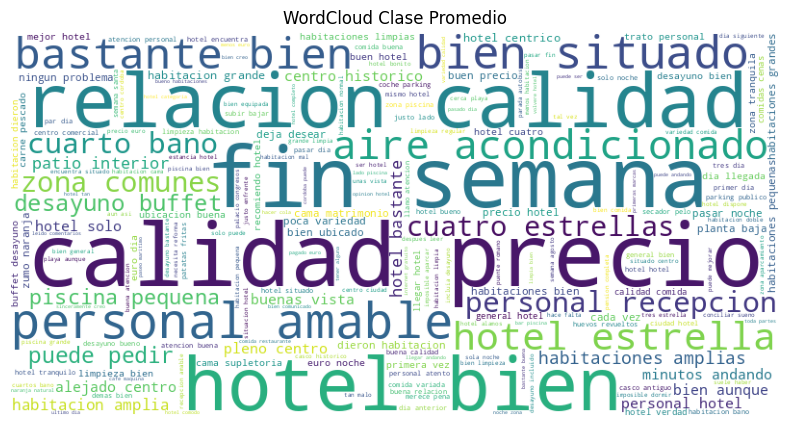

In [65]:
# Clase Promedio (1)
texto_unido_n = ' '.join(df[df['rank'] == 1]['processed_review'].sum())
wordcloud_n = WordCloud(width=800, height=400, background_color='white', collocation_threshold = 3).generate(texto_unido_n)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Promedio')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()


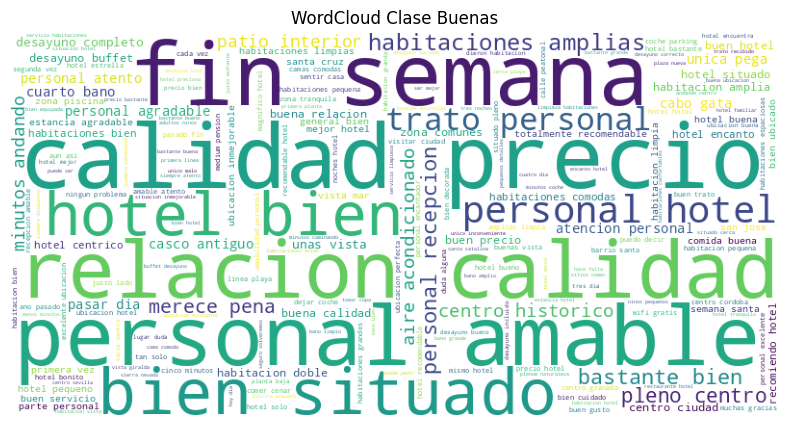

In [66]:
# Clase Buenas (2)
texto_unido_n = ' '.join(df[df['rank'] == 2]['processed_review'].sum())
wordcloud_n = WordCloud(width=800, height=400, background_color='white', collocation_threshold = 3).generate(texto_unido_n)
plt.figure(figsize=(10, 5))
plt.title('WordCloud Clase Buenas')
plt.imshow(wordcloud_n)
plt.axis('off')
plt.show()

In [ ]:
# Guardar DataFrame como pickle
#df.to_pickle('/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea1/df_procesado.pkl')
df.to_pickle('/content/drive/My Drive/Tarea1/df_procesado.pkl')
# Para cargar
# df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/df_procesado.pkl')